In [117]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamPredictor

In [ ]:
def click_callback(event, x, y, flags, param):
    global click_coords
    if event == cv2.EVENT_LBUTTONDOWN:
        click_coords = [(x, y)]
        cv2.destroyAllWindows()

def get_click_from_user(image_path):
    img = cv2.imread(image_path)
    temp = img.copy()
    cv2.imshow("Point picker", temp)
    cv2.setMouseCallback("Point picker", click_callback)
    cv2.waitKey(0)
    return np.array(click_coords, dtype=np.int32)

def get_hair_mask_with_sam(predictor: SamPredictor, img: np.ndarray, 
                           prompt_points: np.ndarray = None,
                           prompt_labels: np.ndarray = None,
                           ):
    predictor.set_image(img)
    masks, scores, logits = predictor.predict(
        point_coords=prompt_points,
        point_labels=prompt_labels,
        multimask_output=False)
    mask = masks[0].astype(np.uint8) * 255
    return mask

def skeletonize_opencv(image):
    skeleton = np.zeros_like(image)
    elem = cv2.getStructuringElement(cv2.MORPH_CROSS, (3,3))
    while True:
        eroded = cv2.erode(image, elem)
        dilated = cv2.dilate(eroded, elem)
        temp = cv2.subtract(image, dilated)
        skeleton = cv2.bitwise_or(skeleton, temp)
        image = eroded.copy()
        if cv2.countNonZero(image) == 0:
            break
    return skeleton

def process(image_path, predictor, pxl2mkm=3.63):
    img_bgr = cv2.imread(image_path)
    point = get_click_from_user(image_path)
    label = np.array([1])  
    hair_mask = get_hair_mask_with_sam(predictor, img_bgr, prompt_points=point, prompt_labels=label)
    hair_mask = cv2.morphologyEx(hair_mask, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5)))  
    dist = cv2.distanceTransform(hair_mask, cv2.DIST_L2, 5)
    skel = skeletonize_opencv(hair_mask)
    ys, xs = np.where(skel > 0)
    ys_good, xs_good = [], []
    for i in range(1,len(ys)):
        if (ys[i] - ys[i-1])**2 + (xs[i] - xs[i-1])**2 < 25:
            ys_good.append(ys[i])
            xs_good.append(xs[i])
    ys = np.array(ys_good)
    xs = np.array(xs_good)
    radii = dist[ys, xs]
    diameters = 2.0 * radii / pxl2mkm
    orig_color = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    overlay = orig_color.copy()
    alpha = 0.4
    overlay[hair_mask>0] = ((1 - alpha) * overlay[hair_mask>0] + alpha * np.array([0,255,0])).astype(np.uint8)
    overlay_with_skel = overlay.copy()
    overlay_with_skel = cv2.cvtColor(overlay, cv2.COLOR_RGB2RGBA)
    overlay_with_skel[skel > 0] = [255, 0, 0, 255]
    return diameters, hair_mask, dist, overlay_with_skel, skel, orig_color

def visualize(filename, diameters, hair_mask, dist, overlay_with_skel, orig_color, format='jpg'):
    fig, axes = plt.subplots(1, 5, figsize=(25,4))
    axes[0].imshow(orig_color);         
    axes[0].set_title("Original")
    axes[1].imshow(hair_mask, cmap='gray')
    axes[1].set_title("Mask")
    axes[2].imshow(dist, cmap='jet')
    axes[2].set_title("Distance map")
    axes[3].imshow(overlay_with_skel)         
    axes[3].set_title("Processed")
    axes[4].hist(diameters,bins=50,color='teal',density=True,rwidth=0.9)
    axes[4].set_xlabel('diameter, mkm')
    axes[4].set_ylabel('distribution density')
    axes[4].set_title("histogram")
    for ax in axes[:-1]: 
        ax.axis('off')
    plt.tight_layout()
    plt.savefig(filename.replace(f'.{format}',f'_result.{format}'))

def save_res(filename, diameters, hair_mask, dist, overlay_with_skel, skel, format='jpg'):
    group, place = filename.replace(f'.{format}','').split('_')
    plt.figure(figsize=(10,7))
    plt.hist(diameters,bins=50,color='teal',density=True,rwidth=0.9)
    plt.xlabel('diameter, mkm')
    plt.ylabel('distribution density')
    plt.title(f'group: {group}; place: {place}')
    plt.savefig(filename.replace(f'.{format}',f'_hist.{format}'))
    cv2.imwrite(filename.replace(f'.{format}',f'_mask.{format}'),hair_mask)
    cv2.imwrite(filename.replace(f'.{format}',f'_dist.{format}'), cv2.applyColorMap(cv2.normalize(dist, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8), cv2.COLORMAP_JET))
    cv2.imwrite(filename.replace(f'.{format}',f'_processed.{format}'),overlay_with_skel)
    cv2.imwrite(filename.replace(f'.{format}',f'_skel.{format}'),skel)
    np.save(filename.replace(f'.{format}','.npy'), diameters)

In [114]:
sam = sam_model_registry['vit_b'](checkpoint='../sam_vit_b_01ec64.pth')
predictor = SamPredictor(sam)

acid_middle.jpg 50.27


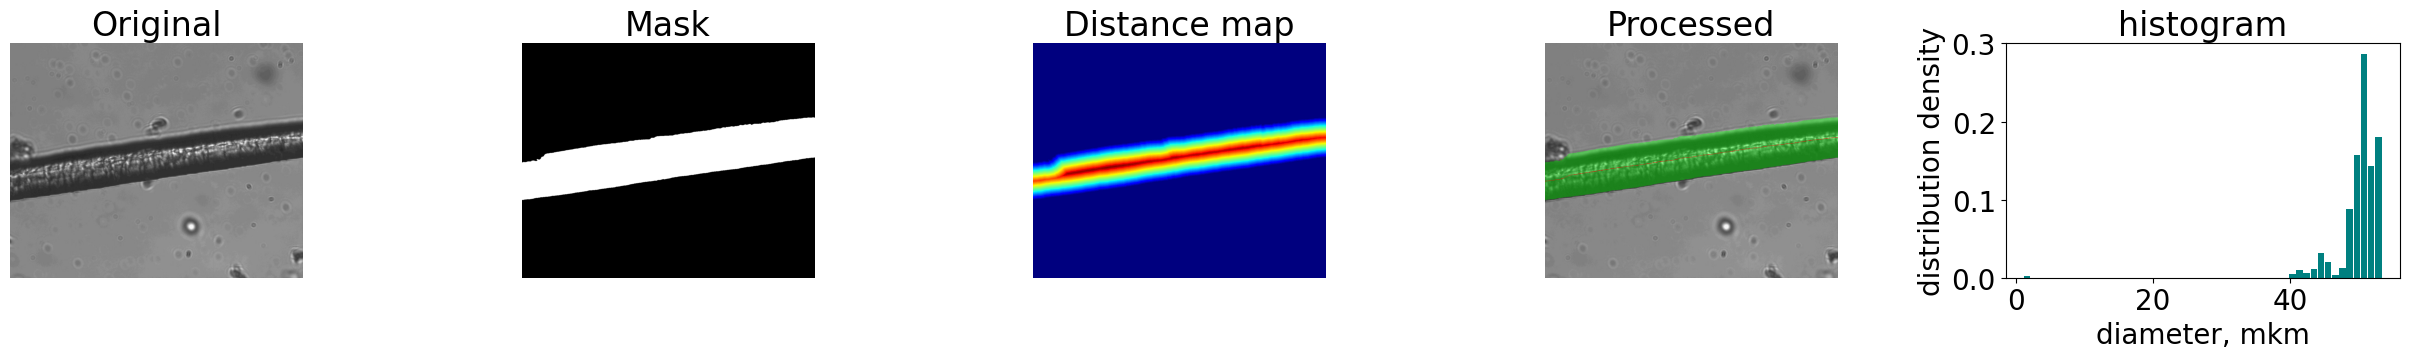

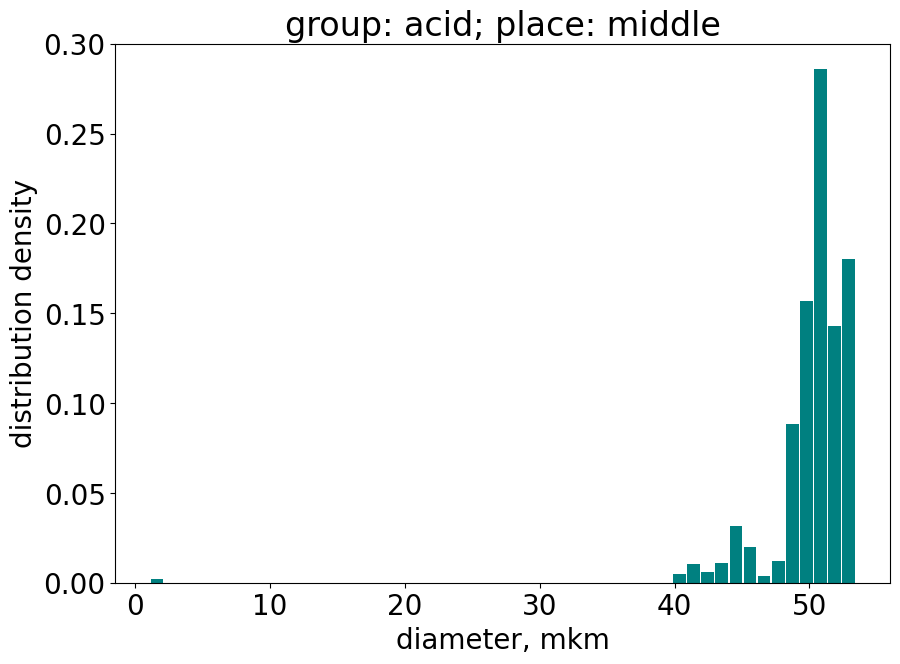

In [ ]:
filenames = os.listdir('../hairs/')
for filename in filenames:
    path = "C:/Users/user1/Downloads/hairs/" + filename
    diameters, hair_mask, dist, overlay_with_skel, skel, orig_color = process(path, predictor)
    visualize(filename, diameters, hair_mask, dist, overlay_with_skel, orig_color)
    save_res(filename, diameters, hair_mask, dist, overlay_with_skel, skel)
    print(f"{filename} {np.mean(diameters):.2f}")

In [120]:
data = {}
for filename in os.listdir('data/'):
    if filename.endswith('.npy'):
        d = np.load(f'data/{filename}')
        group, place = filename.replace('.npy','').split('_')
        if not group in data.keys():
            data[group] = {place : np.mean(d)}
        else:
            data[group][place] = np.mean(d)

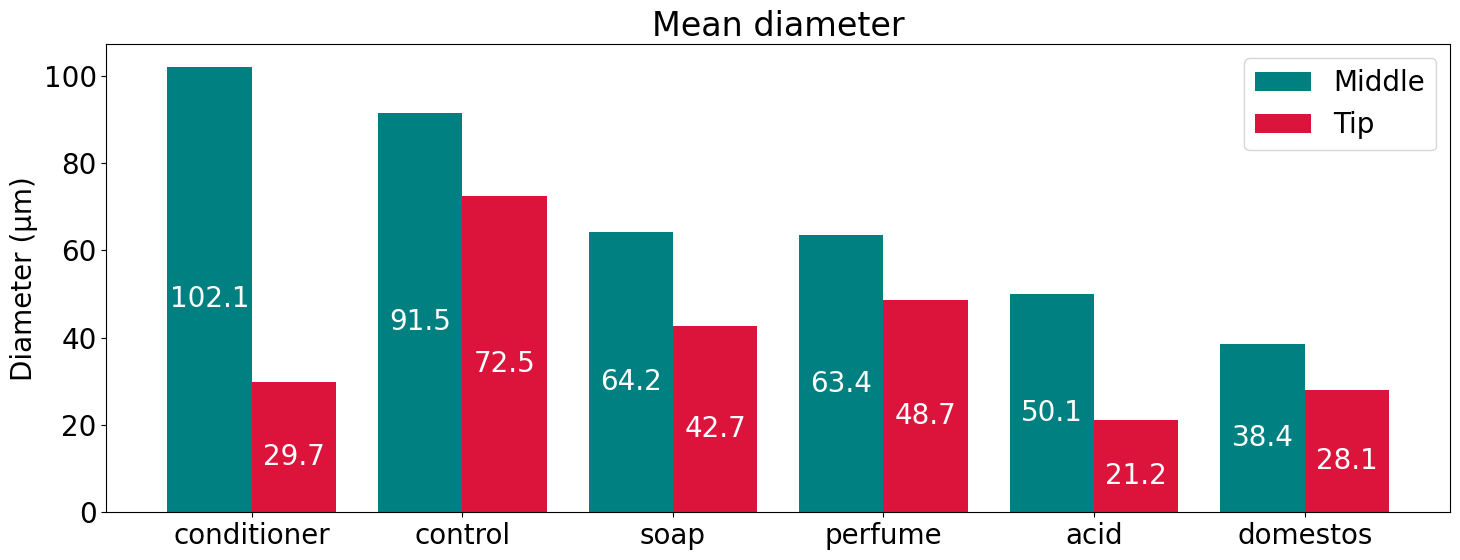

In [ ]:
categories = list(data.keys())
middle = [v['middle'] for v in data.values()]
tip = [v['tip'] for v in data.values()]

sorted_indices = np.argsort(middle)[::-1]
categories = [categories[i] for i in sorted_indices]
middle = [middle[i] for i in sorted_indices]
tip = [tip[i] for i in sorted_indices]

x = np.arange(len(categories))
width = 0.4

fig, ax = plt.subplots(figsize=(15, 6))
rects1 = ax.bar(x - width/2, middle, width, label='Middle', color='teal')
rects2 = ax.bar(x + width/2, tip, width, label='Tip', color='crimson')

ax.set_ylabel('Diameter (µm)')
ax.set_title('Mean diameter')
ax.set_xticks(x)
ax.set_xticklabels(categories, rotation=0, ha='center')
ax.legend()

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.1f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height*0.5),
                    xytext=(0, 3),
                    color='white',
                    textcoords="offset points",
                    ha='center', va='top')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.savefig('diagrams/mean_diameter.png')
plt.show()